In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
import os
from PIL import Image
import numpy as np
import utils
import matplotlib.pyplot as plt

In [2]:
args = {}
args["data_dir"] = "data/segmentation02/segmentation"
args["data"] = "segmentation02"
args["lr"] = 0.01
utils.create_data_file_lists(args["data_dir"])
utils.split_train_to_val(args["data"], args["data_dir"], val_ratio=0.1)

In [9]:
dataloaders, dataset_sizes = utils.get_dataloaders(
            args["data"], args["data_dir"], ["train", "val"], batch_size=4, num_workers=8
        )

In [4]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        self.downsample = nn.ModuleList([
            nn.Sequential(
                nn.Conv2d(1, 128, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
            ),
            nn.Sequential(
                nn.Conv2d(128, 64, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
            ),
            nn.Sequential(
                nn.Conv2d(64, 64, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=2, stride=2)
            )
        ])
        self.upsample = nn.ModuleList([
            nn.Sequential(
                nn.Upsample(scale_factor=2, mode="bilinear", align_corners=True),
                nn.Conv2d(64, 64, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
            ),
            nn.Sequential(
                nn.Conv2d(128, 128, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(128, 4, kernel_size=1),
            ),
        ])
        self.act = nn.Sigmoid()

    def forward(self, x):
        encoder_outputs = []
        for i, layer in enumerate(self.downsample):
            x = layer(x)
            encoder_outputs.append(x)

        # Decoder (upsampling) with skip connections
        for i, layer in enumerate(self.upsample):
            x = layer(x)
            if i < len(self.upsample) - 1:  # Skip connection for all but last layer
                x = torch.cat([x, encoder_outputs[-(i+2)]], dim=1)  # Concatenate skip connection

        x = self.act(x)
        return x

In [5]:
def get_device(device_str):
    if device_str == "gpu" and torch.cuda.is_available():
        return torch.device("cuda")
    elif device_str == "cpu":
        return torch.device("cpu")
    elif device_str == "mps" and torch.backends.mps.is_available():
        return torch.device("mps")  # You can modify the GPU index if needed
    else:
        print("Warning: Invalid device option. Using CPU.")
        return torch.device("cpu")
device = get_device("mps")

In [50]:
model = UNet()
loss_fn = nn.BCELoss(reduction="none")
# loss_fn = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=args["lr"])
model = model.to(device)

In [7]:
def image_to_arrag(image):
    return image.permute(1, 2, 0).cpu().detach().numpy().astype("float")

In [8]:
images, masks = next(iter(dataloaders["train"]))
print(images.shape, masks.shape)

torch.Size([16, 1, 256, 256]) torch.Size([16, 4, 256, 256])


In [10]:
masks.min(), masks.max()

(tensor(0.), tensor(1.))

In [11]:
def mask_class_to_image(tensor):
  if tensor.ndim == 3:
    tmp = tensor.argmax(dim=0)
  else:
    tmp = tensor.argmax(dim=1)
  tmp = tmp / tmp.max()
  return tmp
def mask_class_to_image(tensor):
  tensor = tensor / tensor.max()
  return tensor

def masks_to_inage(masks):
  output_masks = torch.argmax(masks, dim=1)
  output_masks = output_masks / output_masks.max()
  return output_masks

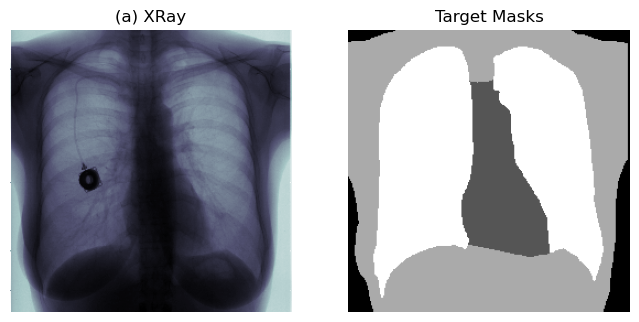

In [12]:
idx=0
fig=plt.figure(figsize=(8,4))
fig.add_subplot(121)
plt.imshow(image_to_arrag(images[idx]), cmap=plt.cm.bone)
plt.title("(a) XRay")
plt.axis("off")
fig.add_subplot(122)
plt.imshow(masks_to_inage(masks)[idx], cmap="gray")
plt.title("Target Masks")
plt.axis("off")
plt.show()

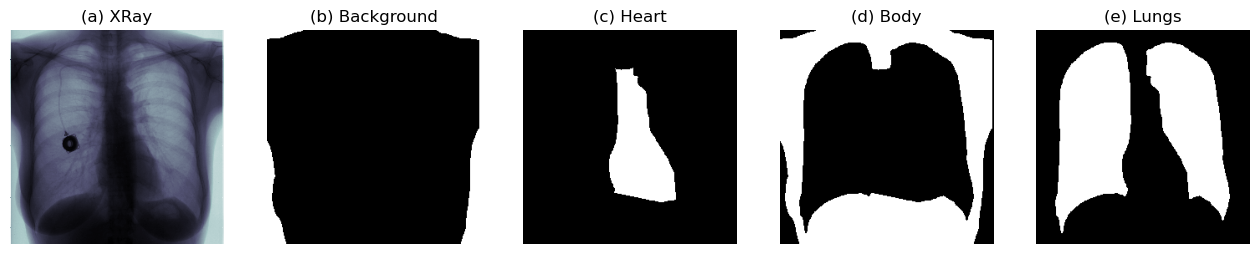

In [13]:
idx=0
fig=plt.figure(figsize=(16,4))
fig.add_subplot(151)
plt.imshow(image_to_arrag(images[idx]), cmap=plt.cm.bone)
plt.title("(a) XRay")
plt.axis("off")
fig.add_subplot(152)
plt.imshow(masks[idx][0], cmap="gray")
plt.title("(b) Background")
plt.axis("off")
fig.add_subplot(153)
plt.imshow(masks[idx][1], cmap="gray")
plt.title("(c) Heart")
plt.axis("off")
fig.add_subplot(154)
plt.imshow(masks[idx][2], cmap="gray")
plt.title("(d) Body")
plt.axis("off")
fig.add_subplot(155)
plt.imshow(masks[idx][3], cmap="gray")
plt.title("(e) Lungs")
plt.axis("off")
plt.show()

In [14]:
from tqdm import tqdm

In [51]:
channel_weights = torch.tensor([0.7,10.0,0.7,0.7]).view(1,4,1,1).to(device)

In [52]:
def train_model(model, loss_fn, optimizer, dataloaders, dataser_sizes, num_epochs, mode):
    model.train()
    train_losses, val_losses = [], []
    for epoch in range(num_epochs):
        for phase in ["train", "val"]:
            if phase=="train":
                model.train()
            else:
                model.eval()
            running_loss=0.0
            with tqdm(total=len(dataloaders[phase]), desc=f'{phase.capitalize()} Epoch {epoch+1}/{num_epochs}', unit='batch') as pbar:
                for inputs, labels in dataloaders[phase]:
                    inputs, labels = inputs.to(device), labels.to(device)
                    optimizer.zero_grad()
                    with torch.set_grad_enabled(phase=="train"):
                        outputs = model(inputs)
                        # print(outputs.max(), outputs.max())
                        loss = loss_fn(outputs.view(-1, 4, 256, 256), labels)
                        # print(loss.shape, loss)
                        loss = torch.mean(channel_weights*loss)
                        if phase=="train":
                            loss.backward()
                            optimizer.step()
                        running_loss += loss.item()
                    pbar.update(1)
            epoch_loss = running_loss / dataset_sizes[phase]
            if phase=="train":
                train_losses.append(epoch_loss)
            else:
                val_losses.append(epoch_loss)
        print(f"Epoch {epoch+1}/{num_epochs} -> Train Loss: {train_losses[-1]:.4f}, Val Loss: {val_losses[-1]:.4f}")

    return model, train_losses, val_losses

model, train_losses, val_losses = train_model(model, loss_fn, optimizer, dataloaders, dataset_sizes, 10, "segmentation")

KeyError: 'train'

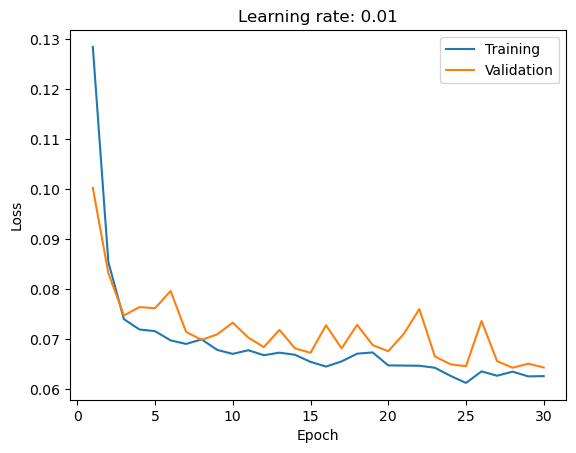

In [24]:
def plot_loss(train_losses, val_losses, learning_rate):
    plt.plot(range(1, len(train_losses) + 1), train_losses, label="Training")
    plt.plot(range(1, len(val_losses) + 1), val_losses, label="Validation")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.title(f"Learning rate: {learning_rate}")
    plt.legend()
    plt.show()
plot_loss(train_losses, val_losses, args["lr"])

In [25]:
dataloaders, dataset_sizes = utils.get_dataloaders(
            args["data"], args["data_dir"], ["test"]
        )

In [27]:
def test_model(model, loss_fn, dataloader, dataset_size):
    model.eval()
    test_loss = 0.0
    all_outputs = []
    all_targets = []
    all_inputs = []
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs.view(-1, 4, 256, 256), labels)
            loss = torch.mean(channel_weights*loss)
            test_loss += loss.item()
            all_outputs.append(outputs.cpu())
            all_targets.append(labels.cpu())
            all_inputs.append(inputs.cpu())
    test_loss = test_loss / dataset_size
    all_inputs, all_outputs, all_targets = torch.cat(all_inputs), torch.cat(all_outputs), torch.cat(all_targets)
    print(f"Test Loss: {test_loss:.4f}")
    return all_inputs, all_outputs, all_targets
inputs, outputs, targets = test_model(model, loss_fn, dataloaders["test"], dataset_sizes["test"])

Test Loss: 0.0656


In [28]:
def calculate_iou(pred_masks, true_masks, threshold=0.5):
    # Binarize predicted masks based on the threshold
    pred_masks = (pred_masks > threshold).float()

    intersection = torch.sum(pred_masks * true_masks, dim=(2, 3))  # Intersection
    union = torch.sum(pred_masks + true_masks, dim=(2, 3)) - intersection  # Union

    iou = intersection / (union + 1e-8)  # Add epsilon to avoid division by zero
    return torch.mean(iou)
print("mIoU: ", calculate_iou(outputs, targets, 0.5))

mIoU:  tensor(0.5055)


In [29]:
def calculate_dice(pred_masks, true_masks, threshold=0.5):
    # Binarize predicted masks based on the threshold
    pred_masks = (pred_masks > threshold).float()

    intersection = torch.sum(pred_masks * true_masks, dim=(2, 3))  # Intersection
    sum_masks = torch.sum(pred_masks + true_masks, dim=(2, 3))  # Sum of masks

    dice = 2. * intersection / (sum_masks + 1e-8)  # Add epsilon to avoid division by zero
    return torch.mean(dice)
print("mDICE: ", calculate_dice(outputs, targets, 0.5))

mDICE:  tensor(0.5975)


In [30]:
def image_to_arrag(image):
    return image.permute(1, 2, 0).cpu().detach().numpy().astype("float")

In [31]:
outputs.max(), outputs.min()

(tensor(1.), tensor(0.))

In [32]:
idx=0
mask_i=1
outputs[idx][mask_i].min(), outputs[idx][mask_i].max(),

(tensor(0.), tensor(0.3802))

In [33]:
output_masks = torch.argmax(outputs, dim=1)
output_masks = output_masks / output_masks.max()

In [34]:
target_masks = torch.argmax(targets, dim=1)
target_masks = target_masks / target_masks.max()

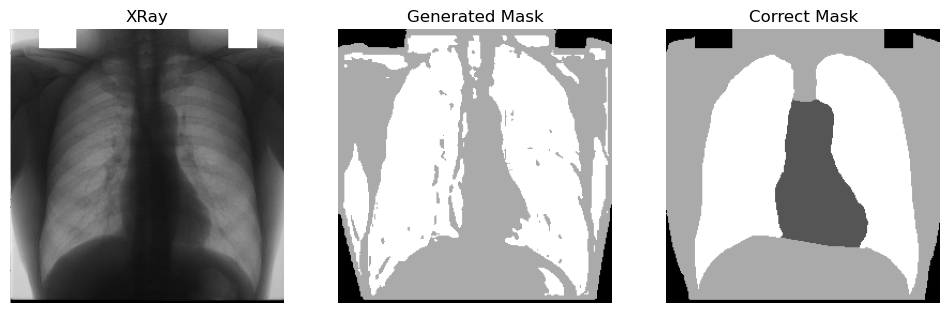

In [48]:
def plot_result(ip, output, target):
    fig = plt.figure(figsize=(12,4))
    fig.add_subplot(131)
    plt.imshow(image_to_arrag(ip), cmap="gray")
    plt.title("XRay")
    plt.axis('off')
    fig.add_subplot(132)
    plt.imshow(output, cmap="gray")
    plt.title("Generated Mask")
    plt.axis('off')
    fig.add_subplot(133)
    plt.imshow(target, cmap="gray")
    plt.title("Correct Mask")
    plt.axis('off')
    plt.show()
idx=12
plot_result(inputs[idx], output_masks[idx], target_masks[idx])

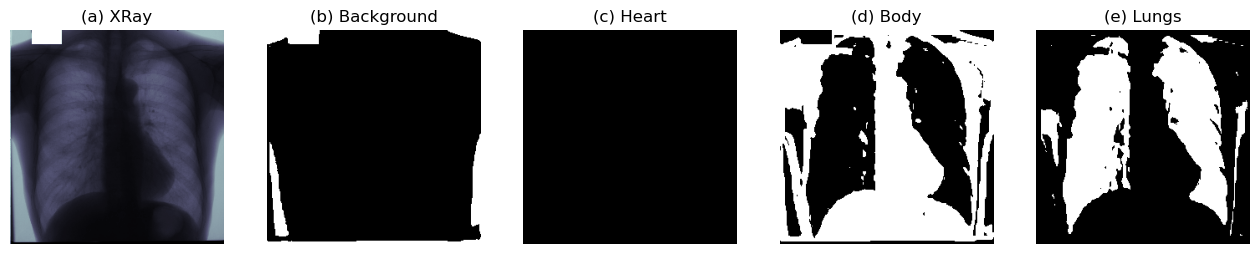

In [49]:
idx=0
outputs_sep=(outputs>0.5).float()
fig=plt.figure(figsize=(16,4))
fig.add_subplot(151)
plt.imshow(image_to_arrag(inputs[idx]), cmap=plt.cm.bone)
plt.title("(a) XRay")
plt.axis("off")
fig.add_subplot(152)
plt.imshow(outputs_sep[idx][0], cmap="gray")
plt.title("(b) Background")
plt.axis("off")
fig.add_subplot(153)
plt.imshow(outputs_sep[idx][1], cmap="gray")
plt.title("(c) Heart")
plt.axis("off")
fig.add_subplot(154)
plt.imshow(outputs_sep[idx][2], cmap="gray")
plt.title("(d) Body")
plt.axis("off")
fig.add_subplot(155)
plt.imshow(outputs_sep[idx][3], cmap="gray")
plt.title("(e) Lungs")
plt.axis("off")
plt.show()